In [1]:
from covid_analysis import *

%matplotlib inline
sns.set(style="whitegrid")
FIGSIZE = [12, 8]

# México

In [2]:
estados_analisis = ["Ciudad de México", "Nuevo León", "Jalisco", "Queretaro"]
estados = load_mariorz()
mexico = {}
for ds_name, ds in estados.items():
    mexico[ds_name] = pd.DataFrame({'Mexico': ds.sum(axis=1)})

## Resumen

### Fecha de Actualización:

In [3]:
mexico['confirmados'].index[-1].strftime("%d-%m-%Y")

'21-05-2020'

### Confirmados

In [4]:
sum(mexico['confirmados'].iloc[-1])

59567

### Nuevos Confirmados

In [5]:
sum(mexico['daily_confirmados'].iloc[-1])

2973

### Fallecimientos

In [6]:
sum(mexico['muertos'].iloc[-1])

6510

### Nuevos Fallecimientos

In [7]:
sum(mexico['daily_muertos'].iloc[-1])

420

## Nacional

### México: Confirmados acumulados

,Mexico
Date,
2020-05-08,31522
2020-05-09,33460
2020-05-10,35022
2020-05-11,36327
2020-05-12,38324
2020-05-13,40186
2020-05-14,42595
2020-05-15,45032
2020-05-16,47144


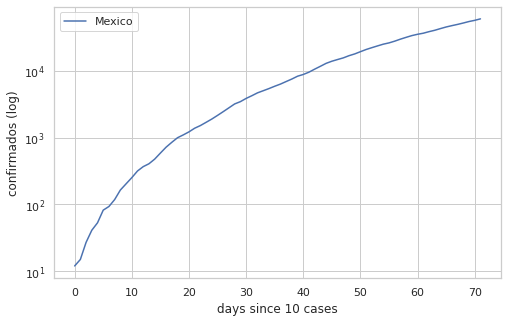

In [8]:
analysis(mexico, ["Mexico"], "confirmados", log=True, smooth=False, since=10)

### México: Confirmados diarios

,Mexico
Date,
2020-05-08,1906
2020-05-09,1938
2020-05-10,1562
2020-05-11,1305
2020-05-12,1997
2020-05-13,1862
2020-05-14,2409
2020-05-15,2437
2020-05-16,2112


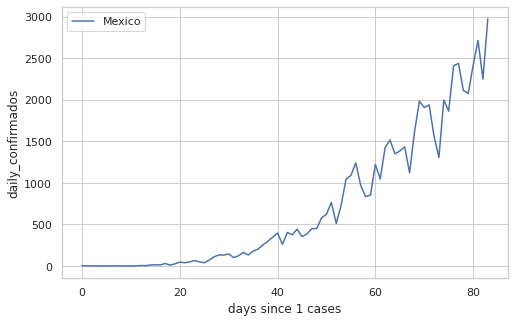

In [9]:
analysis(mexico, ["Mexico"], "daily_confirmados", since=1, smooth=False, log=False)

### México: Fallecimientos acumulados

,Mexico
Date,
2020-05-08,3160
2020-05-09,3353
2020-05-10,3465
2020-05-11,3573
2020-05-12,3926
2020-05-13,4220
2020-05-14,4477
2020-05-15,4767
2020-05-16,5045


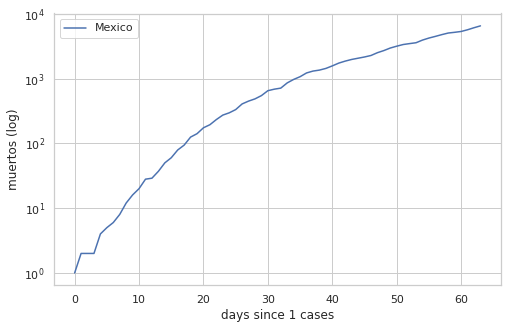

In [10]:
analysis(mexico, ["Mexico"], "muertos", since=1, smooth=False, log=True)

### México: Fallecimientos diarios

,Mexico
Date,
2020-05-08,199
2020-05-09,193
2020-05-10,112
2020-05-11,108
2020-05-12,353
2020-05-13,294
2020-05-14,257
2020-05-15,290
2020-05-16,278


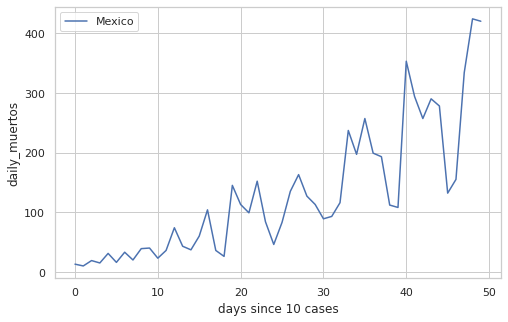

In [11]:
analysis(mexico, ["Mexico"], "daily_muertos", since=10, smooth=False, log=False)

### México: Pruebas reportadas por día, acumuladas

,Mexico
Date,
2020-05-08,123446
2020-05-09,128148
2020-05-10,130956
2020-05-11,135116
2020-05-12,142204
2020-05-13,148497
2020-05-14,155932
2020-05-15,163691
2020-05-16,169097


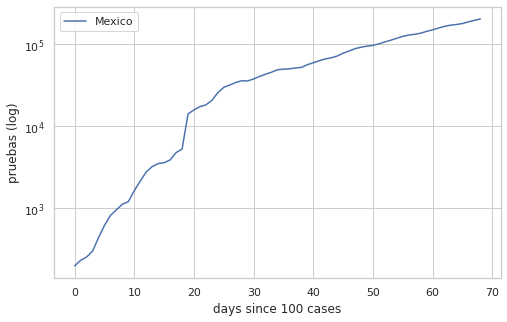

In [12]:
mexico['pruebas'] = mexico['confirmados'].add(mexico['probables']).add(mexico['descartados'])
analysis(mexico, ['Mexico'], 'pruebas', smooth=False, log=True)

### México: Pruebas reportadas por día

,Mexico
Date,
2020-05-08,6235
2020-05-09,4702
2020-05-10,2808
2020-05-11,4160
2020-05-12,7088
2020-05-13,6293
2020-05-14,7435
2020-05-15,7759
2020-05-16,5406


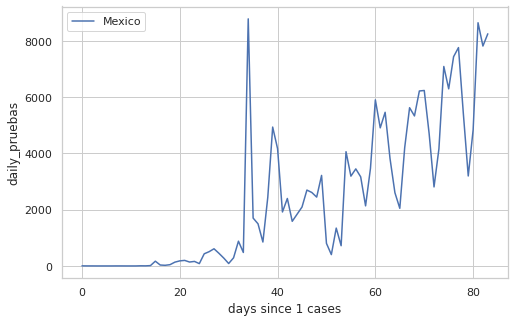

In [13]:
mexico['daily_pruebas'] = mexico['daily_confirmados'].add(mexico['daily_probables']).add(mexico['daily_descartados'])
analysis(mexico, ["Mexico"], "daily_pruebas", since=1, smooth=False, smooth_window=7, log=False)#, show_last_days=50)

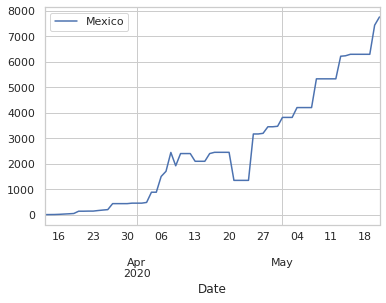

In [14]:
mexico['daily_pruebas'].rolling(window=7).median()[-70:].plot(logy=False)

### México: Positividad 
Proporción de confirmados del total de pruebas reportadas por día

,Mexico
Date,
2020-05-08,0.305694
2020-05-09,0.412165
2020-05-10,0.556268
2020-05-11,0.313702
2020-05-12,0.281744
2020-05-13,0.295884
2020-05-14,0.324008
2020-05-15,0.314087
2020-05-16,0.390677


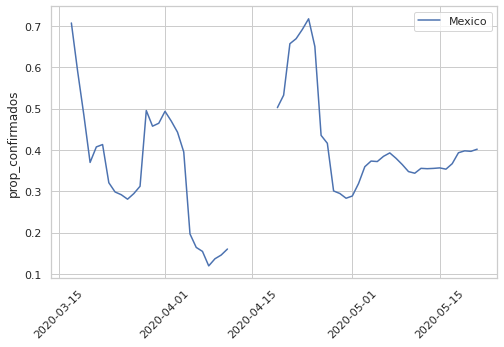

In [15]:
mexico['prop_confirmados'] = mexico['daily_confirmados'] / mexico['daily_pruebas']
analysis(mexico, ['Mexico'], 'prop_confirmados', smooth=True, log=False, since=None)

,Mexico
Date,
2020-05-08,0.255351
2020-05-09,0.261104
2020-05-10,0.267433
2020-05-11,0.268858
2020-05-12,0.269500
2020-05-13,0.270618
2020-05-14,0.273164
2020-05-15,0.275104
2020-05-16,0.278799


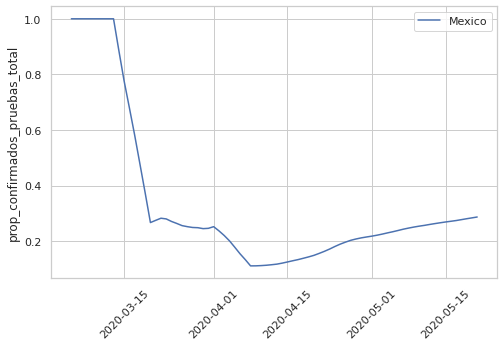

In [16]:
mexico['prop_confirmados_pruebas_total'] = mexico['confirmados'] / mexico['pruebas']
analysis(mexico, ['Mexico'], 'prop_confirmados_pruebas_total', smooth=True, smooth_window=7, log=False, since=None)

### México: proporción de fallecimientos a pruebas, acumulados

,Mexico
Date,
2020-05-08,0.025598
2020-05-09,0.026165
2020-05-10,0.026459
2020-05-11,0.026444
2020-05-12,0.027608
2020-05-13,0.028418
2020-05-14,0.028711
2020-05-15,0.029122
2020-05-16,0.029835


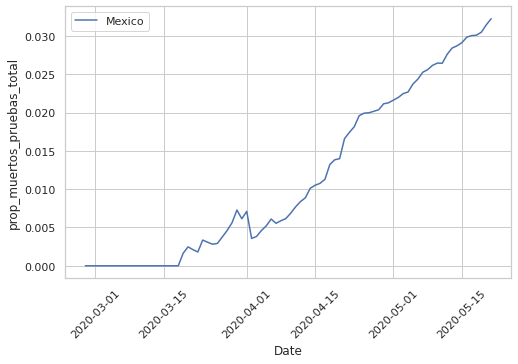

In [17]:
mexico['prop_muertos_pruebas_total'] = mexico['muertos'] / mexico['pruebas']
analysis(mexico, ['Mexico'], 'prop_muertos_pruebas_total', smooth=False, log=False, since=None)

,Mexico
Date,
2020-05-08,0.100247
2020-05-09,0.100209
2020-05-10,0.098938
2020-05-11,0.098357
2020-05-12,0.102442
2020-05-13,0.105012
2020-05-14,0.105106
2020-05-15,0.105858
2020-05-16,0.107013


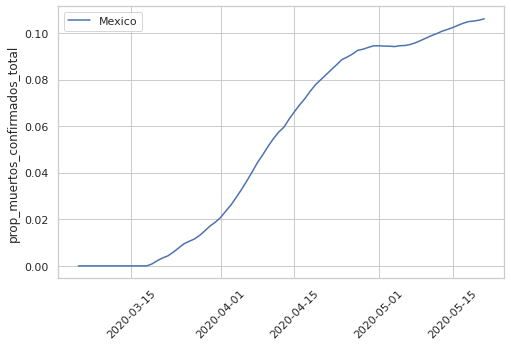

In [18]:
mexico['prop_muertos_confirmados_total'] = mexico['muertos'] / mexico['confirmados']
analysis(mexico, ['Mexico'], 'prop_muertos_confirmados_total', smooth=True, smooth_window=7, log=False, since=None)

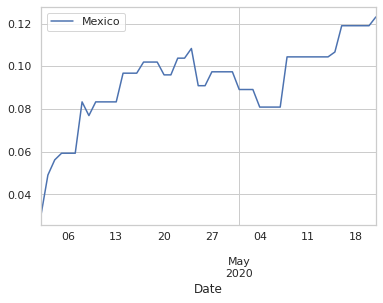

In [19]:
mexico['prop_muertos_confirmados_daily'] = mexico['daily_muertos'] / mexico['daily_confirmados']
mexico['prop_muertos_confirmados_daily'].rolling(window=7).median()[-50:].plot()

## Estados

### Estados: Confirmados acumulados

Estado,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-05-08,10276,609,559,220
2020-05-09,10911,616,595,230
2020-05-10,11599,650,597,248
2020-05-11,11905,672,640,270
2020-05-12,12572,694,671,291
2020-05-13,13095,724,703,332
2020-05-14,13938,762,751,359
2020-05-15,14878,784,771,379
2020-05-16,15609,800,802,421


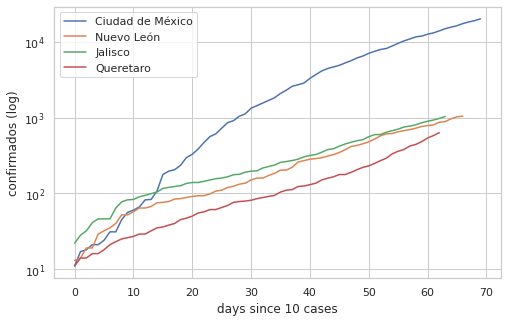

In [38]:
analysis(estados, estados_analisis, "confirmados", since=10, log=True, smooth=False)

### Estados: Confirmados diarios

,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-05-08,743,35,49,15
2020-05-09,635,7,36,10
2020-05-10,688,34,2,18
2020-05-11,306,22,43,22
2020-05-12,667,22,31,21
2020-05-13,523,30,32,41
2020-05-14,843,38,48,27
2020-05-15,940,22,20,20
2020-05-16,731,16,31,42


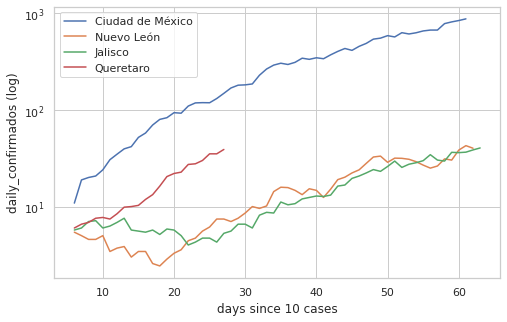

In [39]:
analysis(estados, estados_analisis, "daily_confirmados", since=10, log=True, smooth=True, smooth_window=7)

### Estados: Fallecimientos diarios 

,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-05-08,33,1,6,1
2020-05-09,45,0,1,0
2020-05-10,22,0,4,1
2020-05-11,23,0,3,3
2020-05-12,118,3,0,1
2020-05-13,120,3,4,1
2020-05-14,66,3,5,3
2020-05-15,74,7,5,1
2020-05-16,89,0,7,4


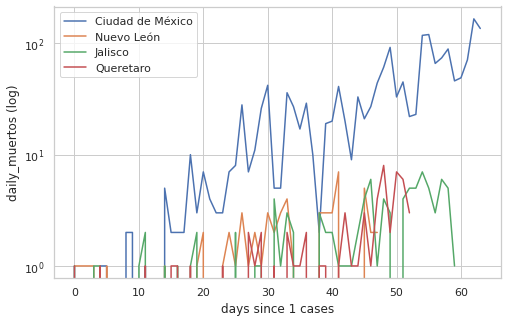

In [22]:
analysis(estados, estados_analisis, "daily_muertos", since=1, log=True, smooth=False)

### Estados: Trayectorias

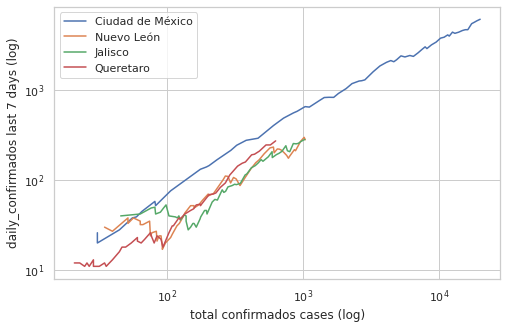

In [23]:
trajectories(estados, estados_analisis, 'confirmados', since=10, window=7)

,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-05-08,32293,7307,6924,1022
2020-05-09,33425,7466,7165,1068
2020-05-10,34132,7665,7312,1113
2020-05-11,35498,7926,7530,1167
2020-05-12,37547,8176,7796,1225
2020-05-13,39723,8473,8012,1276
2020-05-14,41952,8883,8303,1370
2020-05-15,44232,9205,8707,1467
2020-05-16,45604,9387,9004,1548


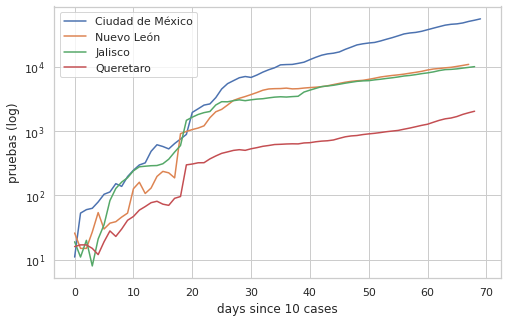

In [41]:
pruebas = {}
for estado in estados['confirmados'].columns:
    pruebas[estado] = estados['confirmados'][estado] + estados['probables'][estado] + estados['descartados'][estado]
estados['pruebas'] = pd.DataFrame(pruebas)
estados['daily_pruebas'] = get_new_per_day(estados['pruebas'])
    
analysis(estados, estados_analisis, "pruebas", since=10, log=True, smooth=False)
#pruebas[-30:].plot(logy=True)

,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-05-08,2106,191,198,23
2020-05-09,1132,159,241,46
2020-05-10,707,199,147,45
2020-05-11,1366,261,218,54
2020-05-12,2049,250,266,58
2020-05-13,2176,297,216,51
2020-05-14,2229,410,291,94
2020-05-15,2280,322,404,97
2020-05-16,1372,182,297,81


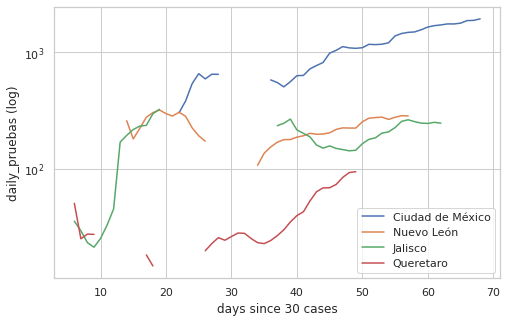

In [42]:
analysis(estados, estados_analisis, "daily_pruebas", since=30, log=True, smooth=True, smooth_window=7)

# Mundo

In [26]:
analysis_countries = ["Mexico", "US", "Spain", "Italy", "Australia", "Korea, South", "Brazil", "United Kingdom"]
world = load_johns_hopkins()

## Mundo: Confirmados acumulados

Country/Region,Mexico,US,Spain,Italy,Australia,"Korea, South",Brazil,United Kingdom
Date,,,,,,,,
2020-05-08,31522,1283929,222857,217185,6918,10840,146894,212629
2020-05-09,33460,1309550,223578,218268,6939,10874,156061,216525
2020-05-10,35022,1329260,224350,219070,6948,10909,162699,220449
2020-05-11,36327,1347881,227436,219814,6970,10936,169594,224332
2020-05-12,38324,1369376,228030,221216,6980,10962,178214,227741
2020-05-13,40186,1390406,228691,222104,6989,10991,190137,230985
2020-05-14,42595,1417774,229540,223096,7019,11018,203165,234440
2020-05-15,45032,1442824,230183,223885,7035,11037,220291,238004
2020-05-16,47144,1467820,230698,224760,7044,11050,233511,241461


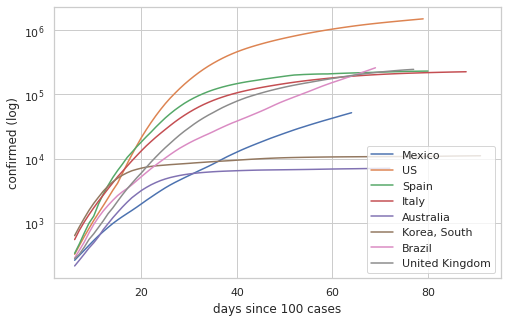

In [27]:
analysis(world, analysis_countries, "confirmed")

## Mundo: Confirmados diarios

,Mexico,US,Spain,Italy,Australia,"Korea, South",Brazil,United Kingdom
Date,,,,,,,,
2020-05-08,1906,26906,1410,1327,5,18,11121,4652
2020-05-09,1938,25621,721,1083,21,34,9167,3896
2020-05-10,1562,19710,772,802,9,35,6638,3924
2020-05-11,1305,18621,3086,744,22,27,6895,3883
2020-05-12,1997,21495,594,1402,10,26,8620,3409
2020-05-13,1862,21030,661,888,9,29,11923,3244
2020-05-14,2409,27368,849,992,30,27,13028,3455
2020-05-15,2437,25050,643,789,16,19,17126,3564
2020-05-16,2112,24996,515,875,9,13,13220,3457


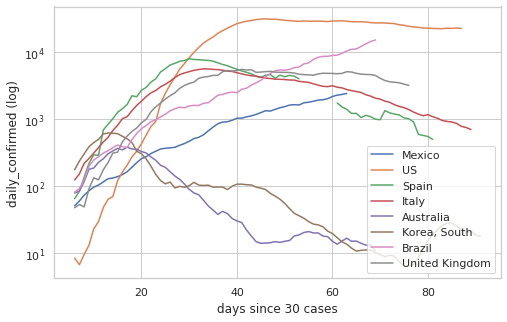

In [28]:
analysis(world, analysis_countries, "daily_confirmed", since=30)

## Mundo: Fallecimientos acumulados

Country/Region,Mexico,US,Spain,Italy,Australia,"Korea, South",Brazil,United Kingdom
Date,,,,,,,,
2020-05-08,3160,77180,26299,30201,97,256,10017,31316
2020-05-09,3353,78795,26478,30395,97,256,10656,31662
2020-05-10,3465,79526,26621,30560,97,256,11123,31930
2020-05-11,3573,80682,26744,30739,97,258,11653,32141
2020-05-12,3926,82356,26920,30911,98,259,12461,32769
2020-05-13,4220,84119,27104,31106,98,260,13240,33264
2020-05-14,4477,85898,27321,31368,98,260,13999,33693
2020-05-15,4767,87530,27459,31610,98,262,14962,34078
2020-05-16,5045,88754,27563,31763,98,262,15662,34546


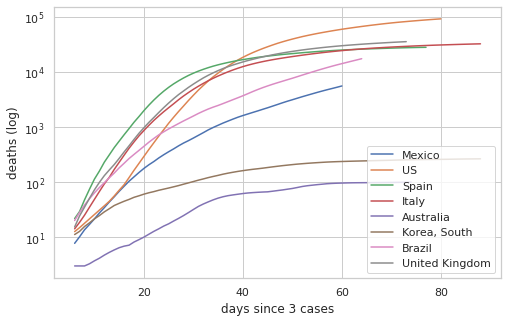

In [29]:
analysis(world, analysis_countries, "deaths", since=3)

## Mundo: Fallecimientos diarios

,Mexico,US,Spain,Italy,Australia,"Korea, South",Brazil,United Kingdom
Date,,,,,,,,
2020-05-08,199,1518,229,243,0,0,827,627
2020-05-09,193,1615,179,194,0,0,639,346
2020-05-10,112,731,143,165,0,0,467,268
2020-05-11,108,1156,123,179,0,2,530,211
2020-05-12,353,1674,176,172,1,1,808,628
2020-05-13,294,1763,184,195,0,1,779,495
2020-05-14,257,1779,217,262,0,0,759,429
2020-05-15,290,1632,138,242,0,2,963,385
2020-05-16,278,1224,104,153,0,0,700,468


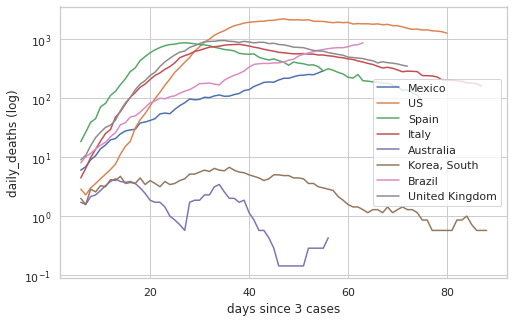

In [30]:
analysis(world, analysis_countries, "daily_deaths", since=3)

## Mundo: Trayectorias de casos confirmados

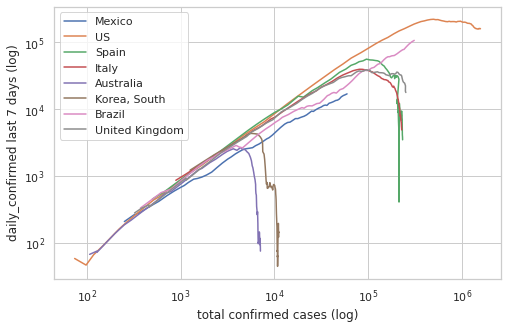

In [31]:
trajectories(world, analysis_countries, 'confirmed', since=50, window=7)

## Querétaro

Estado,Ciudad de México,Queretaro
Date,,
2020-05-08,10276,220
2020-05-09,10911,230
2020-05-10,11599,248
2020-05-11,11905,270
2020-05-12,12572,291
2020-05-13,13095,332
2020-05-14,13938,359
2020-05-15,14878,379
2020-05-16,15609,421


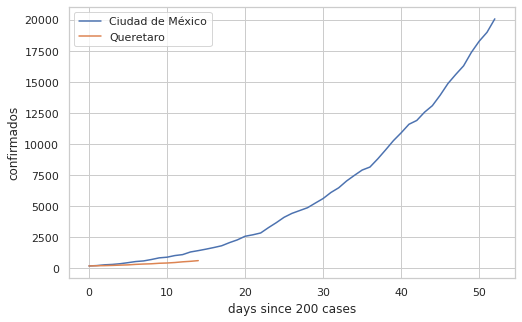

In [32]:
analysis(estados, ["Ciudad de México", "Queretaro"], "confirmados", since=200, log=False, smooth=False, smooth_window=7)

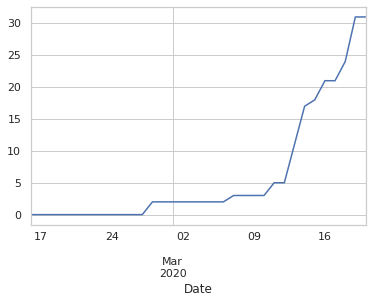

In [33]:
estados['confirmados']['Ciudad de México']['2020-02-16':'2020-03-20'].rolling(window=1).sum().plot()

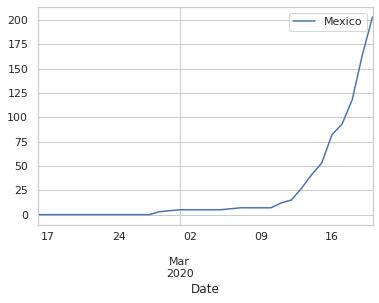

In [34]:
mexico['confirmados']['2020-02-16':'2020-03-20'].plot()

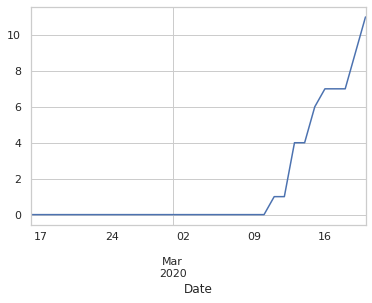

In [35]:
estados['confirmados']['Queretaro']['2020-02-16':'2020-03-20'].plot()

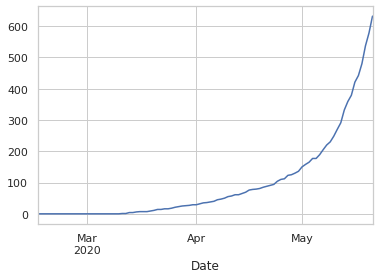

In [36]:
estados['confirmados']['Queretaro']['2020-02-16':].plot()